# 双线性插值知识点补充

1. 双线性插值简单实现
2. 实现初始化反卷积核

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 双线性插值

In [ ]:
def Bilinear_interpolation (src, new_size):
    """使用双线性插值方法放大图像
    para:
        src(np.ndarray):输入图像
        new_size:(tuple): 目标尺寸
    ret:
        dst(np.ndarray): 目标图像
    """
    dst_h, dst_w = new_size # 目标图像的高和宽
    src_h, src_w = src.shape[:2]  #源图像的高和宽
    
    if src_h == dst_h and src_w == dst_w: 
        return src.copy()
    
    scale_x = float(src_w) / dst_w   #缩放比例
    scale_y = float(src_h) / dst_h
    
    #遍历目标图上的每一个像素，由原图的点插入数值
    dst = np.zeros((dst_h, dst_w, 3), dtype=np.uint8) #生成一张目标尺寸大小的空白图，遍历插值
    for n in range(3): #循环channel
        for dst_y in range(dst_h): #循环height
            for dst_x in range(dst_w): #循环width
                #目标像素在源图上的坐标
                # src_x + 0.5 = (dst_x + 0.5) * scale_x 
                src_x = (dst_x + 0.5) * scale_x - 0.5  # 一个像素默认为1*1的小格子，其中心在像素坐标点加0.5的位置
                src_y = (dst_y + 0.5) * scale_y - 0.5
                
                #计算在源图上四个近邻点的位置
                src_x_0 = int(np.floor(src_x))  #向下取整 floor(1.2) = 1.0
                src_y_0 = int(np.floor(src_y))
                src_x_1 = min(src_x_0 + 1, src_w - 1)  #防止出界
                src_y_1 = min(src_y_0 + 1, src_h - 1)
                
                #双线性插值 新图像每个像素的值来自于原图像上像素点的组合插值
                value0 = (src_x_1 - src_x) * src[src_y_0, src_x_0, n] + (src_x - src_x_0) * src[src_y_0, src_x_1, n]
                value1 = (src_x_1 - src_x) * src[src_y_1, src_x_0, n] + (src_x - src_x_0) * src[src_y_1, src_x_1, n]
                dst[dst_y, dst_x, n] = int((src_y_1 - src_y) * value0 + (src_y - src_y_0) * value1)
                
    return dst
            

In [ ]:
if __name__ == '__main__':
    img_in = cv2.imread('2.jpg')
    img_out = Bilinear_interpolation(img_in, (1000,1000))
    cv2.imshow('src_img',img_in)
    cv2.imshow('dst_img',img_out)
    
    key = cv2.waitKey()
    if key == 27:
        cv2.destroyAllWindows()
        
    print(img_in.shape)
    print(img_out.shape)

## 手动初始化转置卷积的卷积核

In [3]:
og = np.ogrid[:4, :4]
print(og[0])
print(og[1])
filt = (1 - abs(og[0] - 2) / 2) * (1 - abs(og[1] - 2) / 2)
print(filt)

[[0]
 [1]
 [2]
 [3]]
[[0 1 2 3]]
[[0.   0.   0.   0.  ]
 [0.   0.25 0.5  0.25]
 [0.   0.5  1.   0.5 ]
 [0.   0.25 0.5  0.25]]


In [9]:
# 手动设计一个滤子
def bilinear_kernel(in_channels, out_channels, kernel_size):
    """使用双线性插值的方法初始化卷积层中卷积核的权重参数
    para:
        in_channels(int): 输入通道数
        out_channels(int): 输出通道数
        kernel_size()
    ret:
        torch.tensor : a bilinear filter kernel
    """
    factor = (kernel_size + 1) // 2
    center = kernel_size/2
    
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    
    return torch.from_numpy(weight)


(177, 284, 3)
(354, 568, 3)


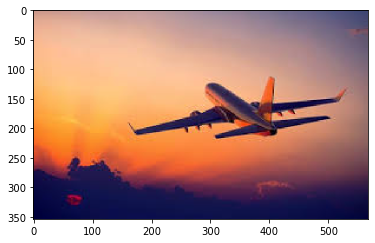

In [21]:
# 测试
x = plt.imread("2.jpg")
print(x.shape)
x = torch.from_numpy(x.astype('float32')).permute(2, 0, 1).unsqueeze(0)  # .unsqueeze(0) 增加 batch_size 通道
conv_trans = nn.ConvTranspose2d(3, 3, 4, 2, 1)
# 将其定义为 bilinear kernel
conv_trans.weight.data = bilinear_kernel(3, 3, 4)
# print(conv_trans.weight)
# print(conv_trans.weight.data)
y = conv_trans(x).data.squeeze().permute(1, 2, 0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)
 